In [1]:
%matplotlib inline

import glob

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import measure, color, morphology
from sklearn.model_selection import train_test_split
import albumentations
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import layers
from skimage.transform import resize
from skimage.io import imread

/Users/alexey/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alexey/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alexey/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alexey/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
from nailgun import data, model, train

In [3]:
def imshow(img, cmap='gray'): 
    plt.figure(figsize=(12, 12))
    plt.imshow(img, cmap=cmap)
    
def show_nails(images):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images): 
        plt.subplot(10, 10, i + 1)
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])

In [4]:
good_images = [imread(filename) for filename in glob.glob('data/good/*')]
bad_images = [imread(filename) for filename in glob.glob('data/bad/*')]

In [5]:
image = bad_images[85]

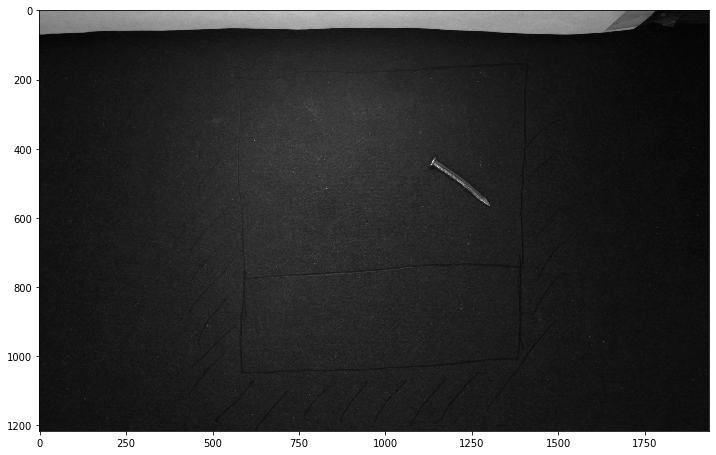

In [6]:
imshow(image)

step 1: crop image to contain only black area

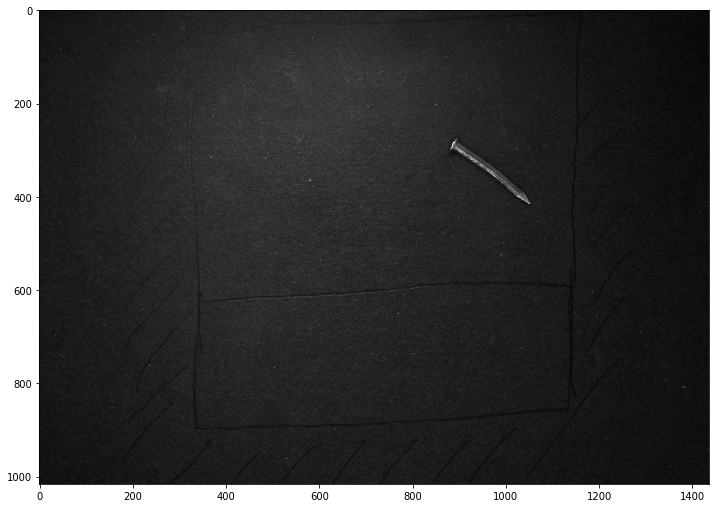

In [7]:
image = image[150:-50, 250:-250]
imshow(image)

step 2: detect edges

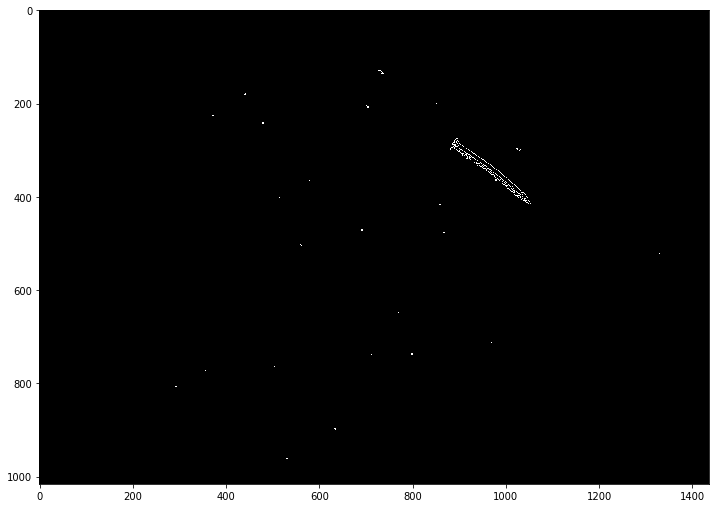

In [8]:
edges = cv2.Canny(image, 40, 250, apertureSize = 3)
imshow(edges)

step 3: emphasize edges and make them look like object segments

In [9]:
edges = morphology.dilation(edges, selem=np.ones((3, 3)))

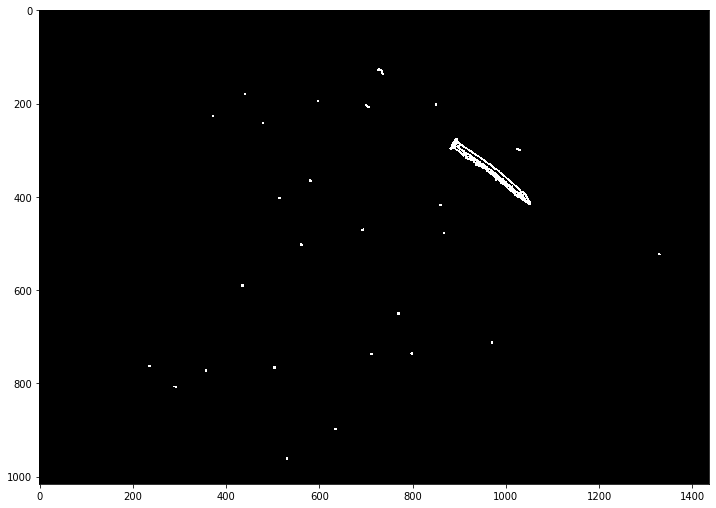

In [10]:
imshow(edges)

step 4: find the largest connected 'white' area

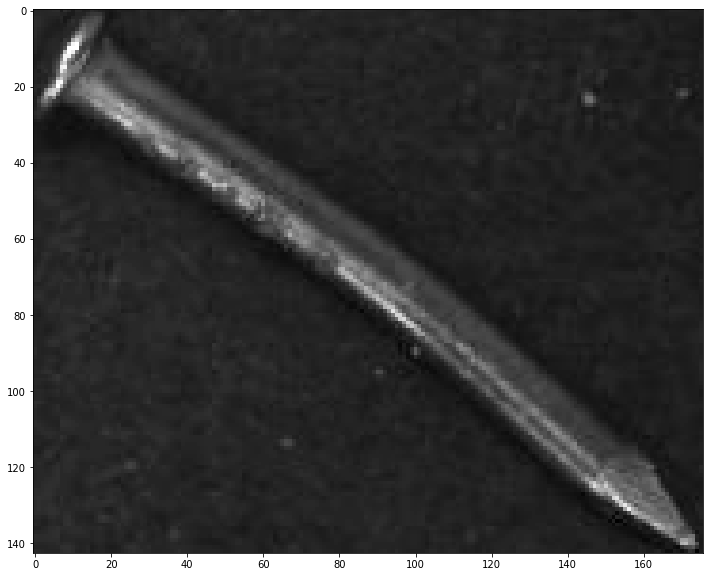

In [11]:
labels = measure.label(edges)
region = max(measure.regionprops(labels), key=lambda x: x.area)
y_min, x_min, y_max, x_max = region.bbox
imshow(image[y_min:y_max, x_min:x_max])


In [12]:
bad_nails = [model.crop_nail(image, 320, 320) for image in bad_images]
good_nails = [model.crop_nail(image, 320, 320) for image in good_images]

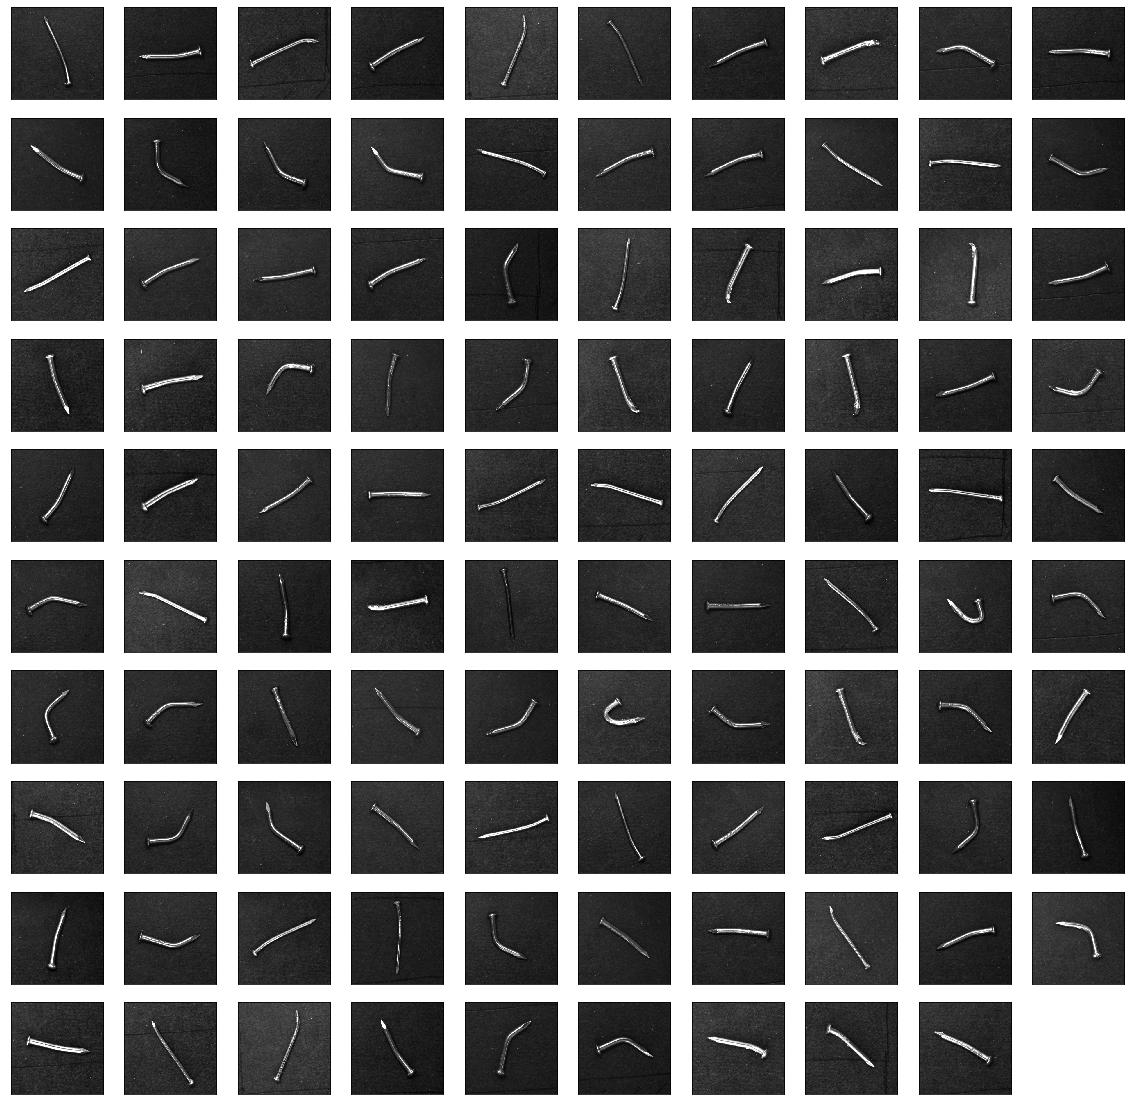

In [13]:
show_nails(bad_nails)

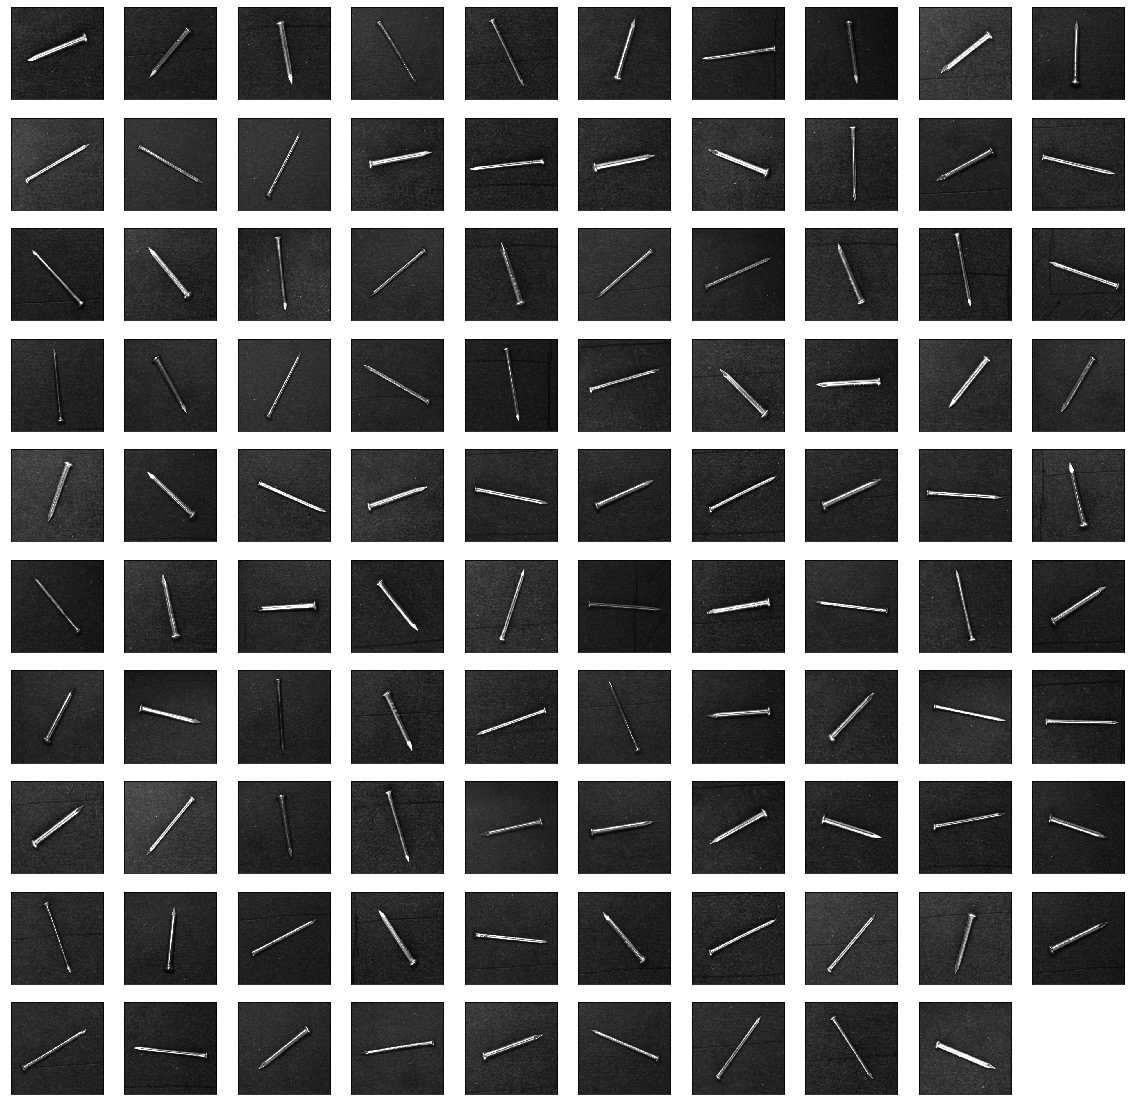

In [14]:
show_nails(good_nails)

# Training

In [15]:
width, height = 32, 32

split data into training/validation subsets

In [16]:
X = np.concatenate([good_nails, bad_nails])
y = np.concatenate([np.zeros(len(bad_nails)), np.ones(len(good_nails))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=38, random_state=0)

# X_test = np.array([resize(image, (height, width)) for image in X_test])
# X_test = model.preprocess_image(X_test)

extend training data using various augmnetations

In [17]:
augmentator = albumentations.Compose([
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=.8),
    albumentations.OneOf([
        albumentations.RandomRotate90(),
        albumentations.Flip(),
    ], p=.6),
    albumentations.Resize(width=width, height=height),
    albumentations.GaussNoise(var_limit=(1, 3)),
])

Augmentation example

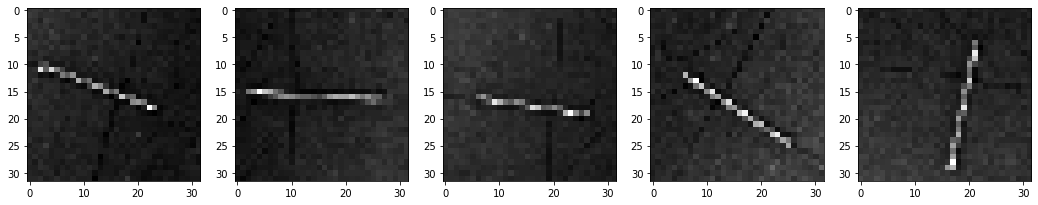

In [18]:
plt.figure(figsize=(18, 6))

for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow(augmentator(image=X_train[13])['image'], cmap='gray')

In [19]:
net = tf.keras.Sequential([
    layers.InputLayer(input_shape=(height, width, 1)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2), strides=(2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2), strides=(2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


net.compile(loss='binary_crossentropy', 
            optimizer='rmsprop',
#             optimizer='adam', 
            metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [55]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_v1_10 (B (None, 6, 6, 32)          128       
_________________________________________________________________
flatten_10 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               147584    
__________

Training batch

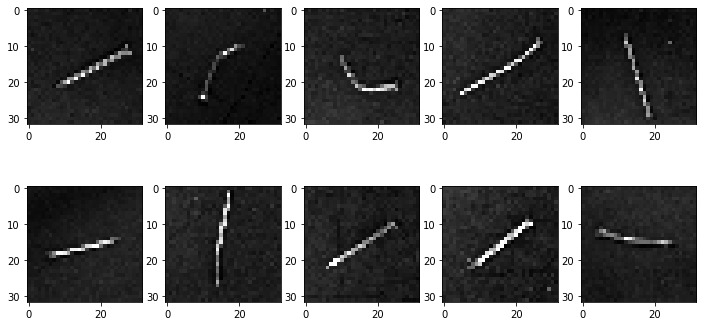

In [21]:
generator = train.AugmentedGenerator(X_train, y_train, 10, augmentator)
plt.figure(figsize=(12, 6))
for i, example in enumerate(generator[0][0], start=1):
    plt.subplot(2, 5, i)
    plt.imshow(example[:, :, 0], cmap='gray')    

In [50]:
net.fit_generator(
    train.AugmentedGenerator(X_train, y_train, 20, augmentator), 
    steps_per_epoch=10000, 
    epochs=10,
#     validation_data=(X_test, y_test),
    validation_data=train.AugmentedGenerator(X_test, y_test, 19, augmentator), 
    validation_steps=20
    
)

Epoch 1/10
8/8 [==============================] - 1s 88ms/step - loss: 0.6582 - acc: 0.5938 - val_loss: 0.6865 - val_acc: 0.5263
Epoch 2/10
8/8 [==============================] - 1s 77ms/step - loss: 0.6722 - acc: 0.6125 - val_loss: 0.6910 - val_acc: 0.5789
Epoch 3/10
8/8 [==============================] - 1s 96ms/step - loss: 0.6632 - acc: 0.5938 - val_loss: 0.6885 - val_acc: 0.6842
Epoch 4/10
8/8 [==============================] - 1s 68ms/step - loss: 0.6249 - acc: 0.6625 - val_loss: 0.6848 - val_acc: 0.5000
Epoch 5/10
8/8 [==============================] - 1s 96ms/step - loss: 0.7087 - acc: 0.5562 - val_loss: 0.6878 - val_acc: 0.6579
Epoch 6/10
8/8 [==============================] - 1s 70ms/step - loss: 0.6757 - acc: 0.5938 - val_loss: 0.6883 - val_acc: 0.5000
Epoch 7/10
8/8 [==============================] - 1s 78ms/step - loss: 0.6688 - acc: 0.6125 - val_loss: 0.6882 - val_acc: 0.6579
Epoch 8/10
8/8 [==============================] - 1s 82ms/step - loss: 0.6603 - acc: 0.6000 - val

In [56]:
net.save('nailmodel', overwrite=True, include_optimizer=False)

In [59]:
net.save_weights('model/')


Consider using a TensorFlow optimizer from `tf.train`.


## How well does your model perform? How does it compare to the simplest baseline model
you can think of?

Model is around 65% accuracy and it slightly better than dummy baseline (50%). 

## How many images are required to build an accurate model?

It's hard to tell, the more the better. It seems like good nails looks alike while bad ones may be quite different and training examples should cover as many cases as possible. I would expect ~2k examples to be quite sufficient for a good model. 

## Where do you see the main challenge in building a model like the one we asked here?

Building a robust nail detector (localization, normalizing and rotating) looks like the hardest part for me.

## What would you do, if there would be only 20 bad images and 100 good images?

Classes could be balanced sampling and augmenting bad images 5 times often.

## What problems might occur if this solution would be deployed to a factory that requires automatic nails quality assurance?

My solution isn't robust to different background, perspective and ligtning conditioins. This may cause problems if factory environment will be altered.
